# model

Please refer to README file for project overview.

In [1]:
data_dir = "../../../DATA/behavioral_cloning_data/"
processed_images_dir = "processed_images_64/"
image_final_width = 64
model_name = "model_p3_keras_tf_vgg_16_224x224x3a_"
nb_epoch = 1
batch_size = 256

In [2]:
import matplotlib.image as mpimg
from scipy import misc
import matplotlib.pyplot as plt
import cv2

In [3]:
import DataHelper
#print(DataHelper.__doc__)
from DataHelper import test_read_csv, read_csv
#print(read_csv.__doc__)
#test_read_csv()
# fetch actual log of driving data
headers, data = read_csv(data_dir + "driving_log.csv")

Using TensorFlow backend.


imported rows 8037


# Create Labels: steering value classes

- Please review notebook "preprocessing", section: "Steering value distribution".
- Training labels have values ranging from -1 to +1.
- When you steer with **keyboard** the STEPS are rather corse, so I think I can get away with **discrete steering angles, i.e. classes**.
- I will start training with 21 equally spread classes, if needed I will increase to 41.
- I want to make sure that my classes include **0.0 (zero)** as it is most common value.

steering_classes [-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9  1. ]
Number of classes 21


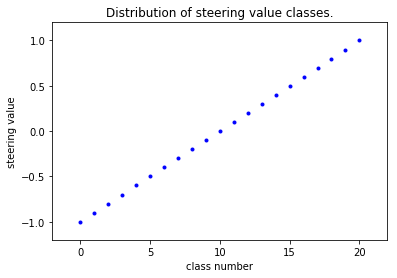

In [4]:
import numpy as np
from numpy import ndarray
number_of_classes = 21 # desired number of classes, could be 41, too.
steering_classes = np.linspace(-1, 1, num=number_of_classes, endpoint=True) 
steering_classes = np.sort(steering_classes)
print("steering_classes", steering_classes)
number_of_classes = steering_classes.shape[0]
print("Number of classes", number_of_classes)

import matplotlib.pyplot as plt
plt.plot(steering_classes, 'b.')
plt.margins(0.1)
plt.title("Distribution of steering value classes.")
plt.xlabel("class number")
plt.ylabel('steering value')
plt.show()

# Split data into training, testing and validation sets

In [5]:
from DataHelper import split_random

# keras actually does it's own split, so here I just reserve small validation set.
training, testing, validation = split_random(data, percent_train=85, percent_test=15) 

print("training",training.shape)
print("testing",testing.shape)
print("validation",validation.shape)

percent_validation 0
training (6831, 7)
testing (1205, 7)
validation (0, 7)


# Extract training features (images)

In [6]:
from DataHelper import get_image_center_values 
image_names = get_image_center_values(training)
print(image_names.shape)
print(image_names[1])

(6831,)
IMG/center_2016_12_01_13_32_46_084.jpg


## Create a list of image paths pointing to 64px version

In [7]:
image_paths = []
for image_name in image_names:
    image_paths.extend([data_dir + processed_images_dir + image_name])
print(image_paths[1]) 

../../../DATA/behavioral_cloning_data/processed_images_64/IMG/center_2016_12_01_13_32_46_084.jpg


training_images matrix shape (6831, 14, 64, 3)


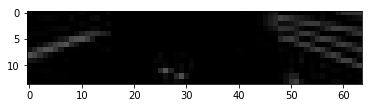

In [8]:
from DataHelper import read_image
training_images = np.array([ read_image(path) for path in image_paths] )

print ("training_images matrix shape", training_images.shape)

plt.imshow(training_images[2], cmap='gray')
plt.show()

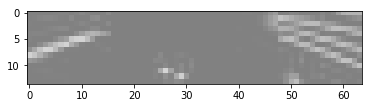

sample_image 
 (14, 64, 3) 
 [[[-0.5       ]
  [-0.5       ]
  [-0.5       ]]

 [[-0.5       ]
  [-0.49607843]
  [-0.48431373]]

 [[-0.49607843]
  [-0.5       ]
  [-0.5       ]]]


In [9]:
from DataHelper import normalize_grayscale
X_train = normalize_grayscale(training_images)
sample_image = X_train[2]

plt.imshow(sample_image, cmap='gray')
plt.show()

show_rows = 3
show_cols = 3
show_channels = 1

print("sample_image \n", sample_image.shape,"\n", sample_image[:show_rows,:show_cols,:show_channels]) #  

In [10]:
def extract_image_single_channel(image):
    show_rows = image.shape[0]
    show_cols = image.shape[1]
    show_channels = 1 # red
    return np.array(  image[:show_rows, :show_cols, 0] )

image_single_channel = extract_image_single_channel(sample_image)
print("image_single_channel \n", image_single_channel[0][:5], type(image_single_channel),image_single_channel.shape)

image_single_channel 
 [-0.5 -0.5 -0.5 -0.5 -0.5] <class 'numpy.ndarray'> (14, 64)


In [11]:
print("training_features_normalized", X_train.shape)  

X_train = extract_image_single_channel(X_train)

print("single channel shape \n", X_train.shape)  
print("single channel column \n", X_train[0:4][0]) 
print("single channel pixel \n", X_train[0][0]) 
print("single channel red value \n", X_train[0][0][0])  
print("single channel red value \n", X_train[0][0][0])  

training_features_normalized (6831, 14, 64, 3)
single channel shape 
 (6831, 14, 3)
single channel column 
 [[-0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.5       ]
 [-0.47254902 -0.47254902 -0.47254902]
 [-0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.5       ]
 [-0.47254902 -0.47254902 -0.47254902]
 [-0.5        -0.5        -0.5       ]
 [-0.48039216 -0.48039216 -0.48039216]
 [-0.5        -0.5        -0.5       ]
 [-0.46078431 -0.46078431 -0.46078431]
 [-0.13137255 -0.13137255 -0.13137255]
 [-0.40588235 -0.40588235 -0.40588235]
 [-0.5        -0.5        -0.5       ]
 [-0.47647059 -0.47647059 -0.47647059]]
single channel pixel 
 [-0.5 -0.5 -0.5]
single channel red value 
 -0.5
single channel red value 
 -0.5


# Training labels (steering angle values) 

In [12]:
from DataHelper import get_steering_values, find_nearest
steering_angles = get_steering_values(training) #array of float32
print(steering_angles.shape)
print(steering_angles[0:6])

(6831,)
[ 0.          0.          0.04262284  0.          0.          0.        ]


# Round steering angles

- I might consider rounding the steering angles to lower amount of training

In [13]:
#X_test = steering_angles # round(steering_angles, 2)

In [14]:
Y_train = np.array([], dtype=np.float32)

for raw_label in steering_angles: # raw_labels[:5]
    #print("raw_label", raw_label)
    rounded_value = float( find_nearest(steering_classes, raw_label) )
    
    # ???? Classification labels should be strings????
    Y_train = np.append(X_test, [rounded_value])
        
print(X_test[0])

0.0


# Encoding Training Labels in one-hot notation

# Keras (with TensorFlow)

https://keras.io/layers/convolutional/

In [15]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import ELU
from keras.layers.core import Flatten, Dense, Dropout, Activation, Lambda

from keras.activations import relu, softmax
from keras.optimizers import SGD
import cv2, numpy as np
from DataHelper import mean_pred, false_rates

from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Convolution1D

### See Model_Keras_VGG_16.py

This file (in the same directory) contains MODEL definiteion for VGG.16.

# Adjust VGG.16 model architecture to match my needs

In [16]:
from keras.layers import InputLayer, Input

model = Sequential()
# apply a 3x3 convolution with 64 output filters on a 14x64 image:
model.add(Convolution2D(64, 3, 3, border_mode='same', 
                        input_shape=(14, 64 ,3), dim_ordering='tf'))
# now model.output_shape == (None, 64, 14, 64)
#model.add(Activation('relu', name="02_ReLU"))
#model.add(Convolution2D(32, 3, 3, border_mode='same', name="03_conv"))
#model.add(Activation('relu', name="04_ReLU"))

#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#The shape of the input to "Flatten" is not fully defined (got (None, 14, 32). 
#Make sure to pass a complete "input_shape" or "batch_input_shape" argument to the first layer in your model.
#The shape of the input to "Flatten" is not fully defined (got (None, 7, 32). 
#Make sure to pass a complete "input_shape" or "batch_input_shape" argument to the first layer in your model.
#model.add(Flatten())

#Negative dimension size caused by subtracting 2 from 1 for 'MaxPool_15' (op: 'MaxPool') with input shapes: [?,1,14,32].
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
#model.add(Dense(256))
#model.add(Activation('relu', name="04_ReLU"))
#model.add(Dense(256))
#model.add(Activation('relu'))

#expected regression to have 4 dimensions, but got array with shape (6831, 21)
model.add(Dense(1, activation='linear', name='regression_result'))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 14, 64, 64)    1792        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
regression_result (Dense)        (None, 14, 64, 1)     65          convolution2d_1[0][0]            
Total params: 1,857
Trainable params: 1,857
Non-trainable params: 0
____________________________________________________________________________________________________


# Compile model (configure learning process)

In [17]:
# Before training a model, you need to configure the learning process, which is done via the compile method.
optimizer='sgd' # | 'rmsprop'
loss_function='mean_squared_error' # | 'binary_crossentropy' | 'mse'
metrics_array=['accuracy'] # , mean_pred, false_rates

model.compile(optimizer, loss_function, metrics_array)

# Replace model with one stored on disk

- If you replace the model, the INPUT dimetions have to be the same as these trained
- Name your models well

In [18]:
from keras.models import load_model

#model = load_model('model.h5') # pick model to resume
#model.summary()

# Train (fit) the model agaist given labels

In [19]:
history = model.fit(X_train, Y_train, nb_epoch=3, 
                    batch_size=batch_size, verbose=1, show_accuracy=True, validation_split=0.2)

#history = model.fit(training_features_normalized, raw_labels, nb_epoch=3, verbose=1, validation_split=0.2)
#history = model.fit(training_features_normalized, training_labels, nb_epoch=3, verbose=1, validation_split=0.2)
#history = model.fit(training_features_normalized, y_one_hot, nb_epoch=run_epochs, validation_split=0.2)
#history = model.fit(single_channel_features, y_one_hot, nb_epoch=run_epochs, validation_split=0.2)

NameError: name 'Y_train' is not defined

In [ ]:

# list all data in history
print(history.history.keys())

training_accuracy = str( history.history['acc'][run_epochs-1])
print("training_accuracy", training_accuracy)

training_error = str( history.history['loss'][run_epochs-1])
print("training_error", training_error)


validation_accuracy = str( history.history['val_acc'][run_epochs-1])
print("validation_accuracy", validation_accuracy)

validation_error = str( history.history['val_loss'][run_epochs-1])
print("validation_error", validation_error)

In [ ]:
model.save(data_dir + "MODELS/" + model_name + training_accuracy + ".h5') # creates a HDF5 file '___.h5'
#del model  # deletes the existing model
#model = load_model('my_model.h5')

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy (bigger better)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'testing accuracy'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Validation error (smaller better)')
plt.ylabel('error')
plt.xlabel('epochs run')
plt.legend(['training error', 'testing error'], loc='lower left')
plt.show()